In [ ]:
import torch 
import torch.nn as nn
import torchvision
import time
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

В 14 Мини ДЗ Вам предстоит самостоятельно сконструировать нейронную сеть и решить задачу классификации рукописных цифр. Можно использовать любую архитектуру и тип нейронных сетей - например полносвязные и/или сверточные.

Использование ноутбука с занятия приветствуется!

In [ ]:
# class ImageClassifier(nn.Module):
#     def __init__(self, input_dim: int, hidden_dim: int, num_classes: int):
#         super().__init__()
        
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, num_classes),
#             nn.Softmax(dim=1)
#         )
    
#     def forward(self, input_batch: torch.Tensor):
#         output_batch = self.linear1(nn.Flatten()(input_batch))
#         output_batch = self.linear2(nn.ReLU()(input_batch))
#         #output_batch = self.model(input_batch)

#         return output_batch

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # сейчас 64 нейрона в первом слое
        self.linear1 = nn.Linear(28 * 28, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 10)  # логиты (logits) для 10 классов
        
    def forward(self, x):
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        x = self.linear3(nn.ReLU()(x))
        return x

Загрузим датасет:

In [ ]:
train_dataset = torchvision.datasets.MNIST('.', download=True)
test_dataset = torchvision.datasets.MNIST('.', download=True, train=False)

train_x, train_y = train_dataset.train_data, train_dataset.train_labels
test_x, test_y = test_dataset.test_data, test_dataset.test_labels

In [ ]:
print('Размер тренировочной выборки:', train_x.shape[0])
print('Размер тестовой выборки:', test_x.shape[0])
print('Размер одного объекта:', test_x.shape[1:])

Размер тренировочной выборки: 60000
Размер тестовой выборки: 10000
Размер одного объекта: torch.Size([28, 28])


Теперь нужно определить нужные компоненты для тренировки:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = ImageClassifier().to(device)
   # input_dim=train_x.shape[1], 
    #hidden_dim=28,
   # num_classes=10
# ).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

А теперь train loop:

In [ ]:
batch_size = 64  # Размер батча (столько объектов обрабатываются нейросетью за один forward pass)
losses = []
eval_losses = []
n_epochs = 8
start_time = time.time()

for epoch in range(n_epochs):
    train_acc = 0
    val_acc = 0
    model.train()
    current_epoch_train_losses = []
    for i in tqdm(range(0, train_x.shape[0], batch_size), 
                  desc='Training epoch {} from {}'.format(epoch, n_epochs)):
        x_batch = train_x[i: i + batch_size].to(device) # Здесь не забудьте перенести батч с данными на GPU
        y_batch = train_y[i: i + batch_size].to(device) # и здесь тоже

        x_batch = torch.flatten(x_batch.float(), start_dim=1)
        
        # Обнулите градиенты в optimizer
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch.long().to(device))
       
        # Сделайте backward
        loss.backward()
        optimizer.step()
        # Сделайте шаг градиентного спуска
        
        y_pred = logits.max(1)[1].detach().cpu().numpy()
        train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
        current_epoch_train_losses.append(loss.item())
    losses.append(np.array(current_epoch_train_losses).mean())
    train_acc /= len(train_x) 
    # Evaluation step
    model.eval()
    current_epoch_eval_losses = []
    for i in range(0, test_x.shape[0], batch_size):
        x_batch = test_x[i: i + batch_size].to(device)
        y_batch = test_y[i: i + batch_size].to(device)

        x_batch = torch.flatten(x_batch.float(), start_dim=1)

        with torch.no_grad():
            # Так как на валидации мы не оптимизируем модель, 
            # то нам не нужно считать градиенты. 
            # Поэтому мы воспользовалиь torch.no_grad(). 
            logits = model(x_batch)
            # посчитайте ошибку по батчу
            eval_loss = criterion(logits, y_batch.long().to(device))
            
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        current_epoch_eval_losses.append(eval_loss.item())
    val_acc /= len(test_x)
    eval_losses.append(np.array(current_epoch_eval_losses).mean())
    clear_output()

    print("Epoch {} of {} took {:.3f}s".format(
    epoch + 1, n_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(eval_loss))
    print("  training accuracy: \t\t\t{:.2f} ".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} ".format(val_acc * 100))


Epoch 8 of 8 took 12.339s
  training loss (in-iteration): 	1.160977
  validation loss (in-iteration): 	0.804752
  training accuracy: 			0.90 
  validation accuracy: 			0.93 


Нарисуйте графики для train и val лоссов - какие выводы/наблюдения вы можете сделать по ним?

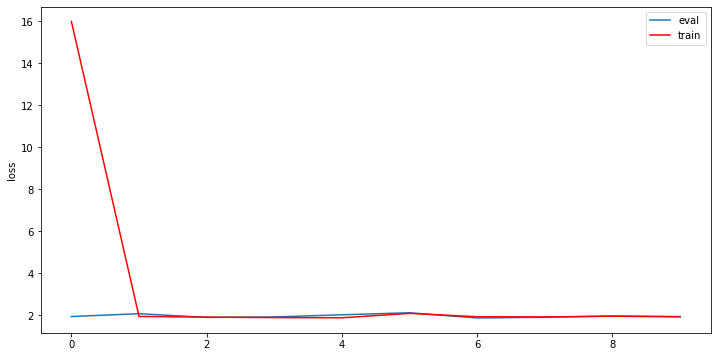

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(12, 6), sharex=True)

ax1.plot(eval_losses)
ax1.set_ylabel("loss")
ax1.plot(losses, color = 'r')
ax1.legend(['eval','train'])

Посчитайте accuracy полученной модели. 

Постарайтесь получить accuracy 0.9, но начиная с 0.8 можно спокойно сдавать.

Дополнительное задание:

Поэкспериментируйте с разными архитектурами (добавить батч нормализацию и дропаут) и гиперпарамтерами. Как изменилось качество модели? 

In [ ]:
# class CNN_BN(nn.Module):
#     def __init__(self): 
#         super(MyNetBN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
#             nn.ReLU(),
#             nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
#             nn.Conv2d(3, 6, 3),
#             nn.BatchNorm2d(6)           # (N, 3, 12, 12) -> (N,  6, 10, 10) 
#         )
#         self.features1 = nn.Sequential(
#             nn.ReLU(),
#             nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(150, 25),         # (N, 150) -> (N, 25)
#             nn.ReLU(),
#             nn.Linear(25,10)            # (N, 25) -> (N, 10)
#         )
        
#     def forward(self, x):
#         x = self.features(x)
#         x = self.features1(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

In [ ]:
# model2 = CNN_BN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# batch_size = 64  # Размер батча (столько объектов обрабатываются нейросетью за один forward pass)
# losses = []
# eval_losses = []
# n_epochs = 8
# start_time = time.time()

# for epoch in range(n_epochs):
#     train_acc = 0
#     val_acc = 0
#     model2.train()
#     current_epoch_train_losses = []
#     for i in tqdm(range(0, train_x.shape[0], batch_size), 
#                   desc='Training epoch {} from {}'.format(epoch, n_epochs)):
#         x_batch = train_x[i: i + batch_size].to(device) # Здесь не забудьте перенести батч с данными на GPU
#         y_batch = train_y[i: i + batch_size].to(device) # и здесь тоже

#        #x_batch = torch.flatten(x_batch.float(), start_dim=1)
        
#         # Обнулите градиенты в optimizer
#         optimizer.zero_grad()
#         logits = model2(x_batch)
#         loss = criterion(logits, y_batch.long().to(device))
       
#         # Сделайте backward
#         loss.backward()
#         optimizer.step()
#         # Сделайте шаг градиентного спуска
        
#         y_pred = logits.max(1)[1].detach().cpu().numpy()
#         train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        
#         current_epoch_train_losses.append(loss.item())
#     losses.append(np.array(current_epoch_train_losses).mean())
#     train_acc /= len(train_x) 
#     # Evaluation step
#     model2.eval()
#     current_epoch_eval_losses = []
#     for i in range(0, test_x.shape[0], batch_size):
#         x_batch = test_x[i: i + batch_size].to(device)
#         y_batch = test_y[i: i + batch_size].to(device)

#         #x_batch = torch.flatten(x_batch.float(), start_dim=1)

#         with torch.no_grad():
#             # Так как на валидации мы не оптимизируем модель, 
#             # то нам не нужно считать градиенты. 
#             # Поэтому мы воспользовалиь torch.no_grad(). 
#             logits = model2(x_batch)
#             # посчитайте ошибку по батчу
#             eval_loss = criterion(logits, y_batch.long().to(device))
            
#             y_pred = logits.max(1)[1].detach().cpu().numpy()
#             val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
#         current_epoch_eval_losses.append(eval_loss.item())
#     val_acc /= len(test_x)
#     eval_losses.append(np.array(current_epoch_eval_losses).mean())
#     clear_output()

#     print("Epoch {} of {} took {:.3f}s".format(
#     epoch + 1, n_epochs, time.time() - start_time))
#     print("  training loss (in-iteration): \t{:.6f}".format(loss))
#     print("  validation loss (in-iteration): \t{:.6f}".format(eval_loss))
#     print("  training accuracy: \t\t\t{:.2f} ".format(train_acc * 100))
#     print("  validation accuracy: \t\t\t{:.2f} ".format(val_acc * 100))